In [ ]:
# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption_2.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_2_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption_3.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_3_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption_4.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_4_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_strong_disruption.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_strong_m0/

In [1]:
import numpy as np
import pandas as pd
from akita_utils.format_io import h5_to_df
import bioframe as bf
from akita_utils.df_utils import filter_by_chromID

In [2]:
df_1 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_m0/STATS_OUT.h5", average=False)
df_2 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_2_m0/STATS_OUT.h5", average=False)
df_3 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_3_m0/STATS_OUT.h5", average=False)
df_4 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_4_m0/STATS_OUT.h5", average=False)
df_strong = h5_to_df("/scratch1/smaruj/tad_disruption/model0_strong_m0/STATS_OUT.h5", average=False)

In [ ]:
# target 1 is Bonev ES Cells, which HiC TAD boundaries have called on

In [3]:
df = pd.concat([df_1, df_2, df_3, df_4, df_strong], axis=0, ignore_index=True)

In [4]:
type_order = [f"down{i}" for i in range(20,0,-1)] + [f"tad{i}" for i in range(1,6)] + [f"up{i}" for i in range(1,21)]

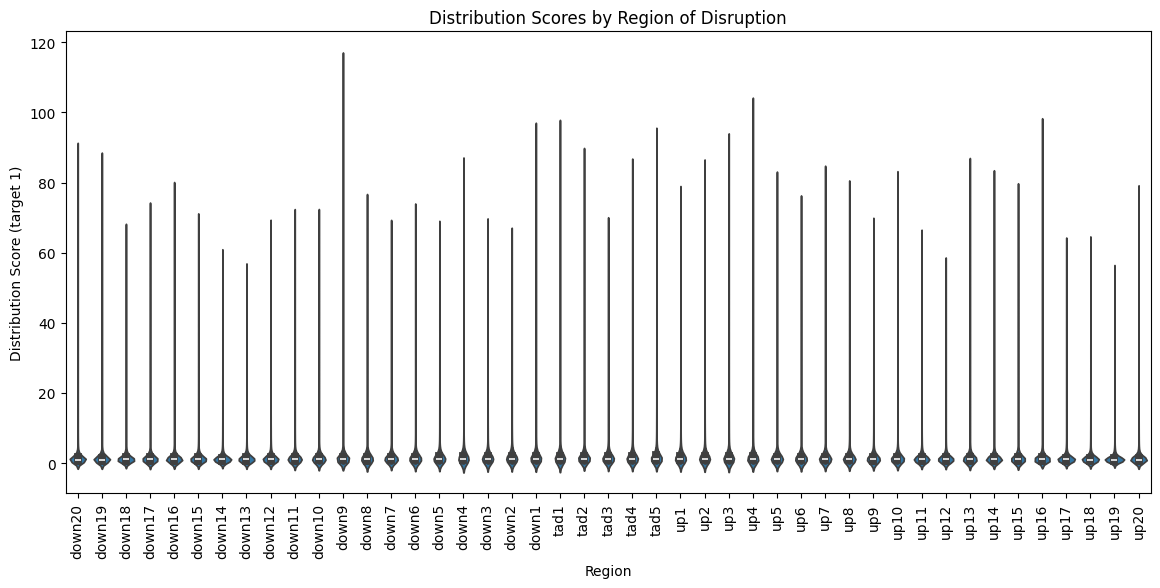

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(14, 6))

# Create the violin plot
sns.violinplot(data=df, x='type', y='SCD_h1_m0_t1', inner='box', order=type_order)

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Distribution Score (target 1)')
plt.title('Distribution Scores by Region of Disruption')
plt.xticks(rotation=90)

# Show the plot
plt.show()

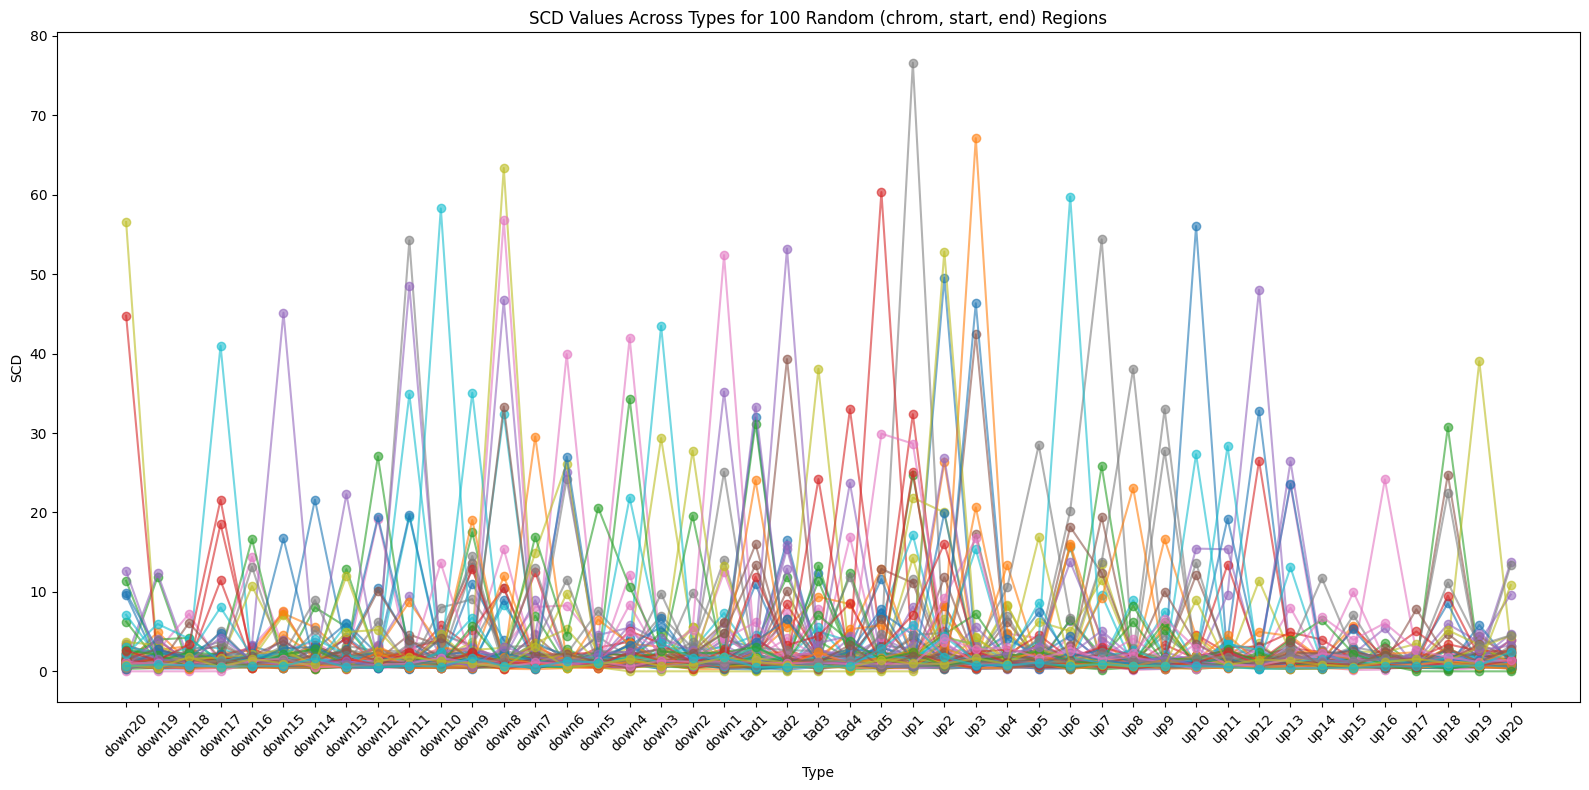

In [6]:
# Randomly sample 100 unique (chrom, start, end) regions
sampled_df = df.drop_duplicates(subset=['chrom', 'start', 'end']).sample(n=100)

# Filter the original dataframe to include only the sampled regions
filtered_df = df[df[['chrom', 'start', 'end']].apply(tuple, axis=1).isin(sampled_df[['chrom', 'start', 'end']].apply(tuple, axis=1))]

# Set up the figure
plt.figure(figsize=(16, 8))

# Create a mapping from type to order
type_mapping = {t: i for i, t in enumerate(type_order)}

# For each sampled region, plot the line connecting SCD values for each type
for (chrom, start, end), group in filtered_df.groupby(['chrom', 'start', 'end']):
    # Sort the group by the defined type order
    group = group.sort_values(by='type', key=lambda x: x.map(type_mapping))
    plt.plot(group['type'], group['SCD_h1_m0_t1'], marker='o', label=f"{chrom}:{start}-{end}", alpha=0.6)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('SCD')
plt.title('SCD Values Across Types for 100 Random (chrom, start, end) Regions')

# Optional: Add legend (can be overwhelming with 100 lines)
# plt.legend(loc='best')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


### Checking for orientation assymetry

In [7]:
# Excluding boundaries with no disruption-sensitive bins
filtered_df = df[df['SCD_h1_m0_t1'] >= 18.705717] # Li threshold (calculated below)

# selecting one bin for a boundary resulting in the highest disruption score
max_SCD_df = filtered_df.groupby(['chrom', 'start', 'end', 'type', 
                                  'rel_disruption_end', 'rel_disruption_start',
                                  'window_end', 'window_start'])["SCD_h1_m0_t1"].max().reset_index()

max_indices = max_SCD_df.groupby(['chrom', 'start', 'end'])['SCD_h1_m0_t1'].idxmax()
unique_max_scd_df = max_SCD_df.loc[max_indices].reset_index(drop=True)

In [9]:
# renaming to overlap with jaspar set of CTCFs
unique_max_scd_df_rn = unique_max_scd_df.rename(columns={"start": "TAD_start", "end": "TAD_end"})
unique_max_scd_df_rn["start"] = unique_max_scd_df_rn["window_start"] + unique_max_scd_df_rn["rel_disruption_start"]
unique_max_scd_df_rn["end"] = unique_max_scd_df_rn["window_start"] + unique_max_scd_df_rn["rel_disruption_end"]

In [10]:
# loading JASPAR CTCF dataset
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
autosomes_only = True

if autosomes_only:
    chromID_to_drop = ["chrX", "chrY", "chrM"]
    
# read jaspar table (all CTCFs in the mouse genome)
jaspar_df = bf.read_table(jaspar_file, schema="jaspar", skiprows=1)
if autosomes_only:
    jaspar_df = filter_by_chromID(jaspar_df, chrID_to_drop=chromID_to_drop)
jaspar_df.reset_index(drop=True, inplace=True)

In [11]:
# overlapping
orient_df_overlap = bf.overlap(unique_max_scd_df_rn, jaspar_df, suffixes=("", "_2"), return_index=False, how="inner")
orient_df_overlap['strand_2'] = orient_df_overlap['strand_2'].replace({'+': '>', '-': '<'})

overlap_strand = orient_df_overlap.groupby(['chrom', 'start', 'end', 'type']).agg({
    'strand_2': lambda x: ''.join(x),   # Concatenate 'type' values
}).reset_index()

In [12]:
# Define a function to classify strand orientation
def classify_strand(strand):
    if '>' in strand and '<' not in strand:
        return 'right'
    elif '<' in strand and '>' not in strand:
        return 'left'
    else:
        return 'other'

In [13]:
# Apply the classification to the strand_2 column
overlap_strand['orientation'] = overlap_strand['strand_2'].apply(classify_strand)

# Group by type and orientation, and count occurrences
grouped_counts = overlap_strand.groupby(['type', 'orientation']).size().unstack(fill_value=0)

# Reindex the DataFrame to ensure the correct order of types
grouped_counts = grouped_counts.reindex(type_order)

In [14]:
type_num_values = [-45.1, -43.0, -41.0, -38.9, -36.9, -34.8, -32.8, -30.7, -28.7, -26.6, 
               -24.6, -22.5, -20.5, -18.4, -16.4, -14.3, -12.3, -10.2, -8.2, -6.1, 
               -4.1, -2.0, 0.0, +2.0, +4.1, +6.1, +8.2, +10.2, +12.3, +14.3, 
               +16.4, +18.4, +20.5, +22.5, +24.6, +26.6, +28.7, +30.7, +32.8, +34.8, 
               +36.9, +38.9, +41.0, +43.0, +45.1]

In [15]:
type_to_num = dict(zip(type_order, type_num_values))

In [16]:
overlap_strand['type_numeric'] = overlap_strand['type'].map(type_to_num)

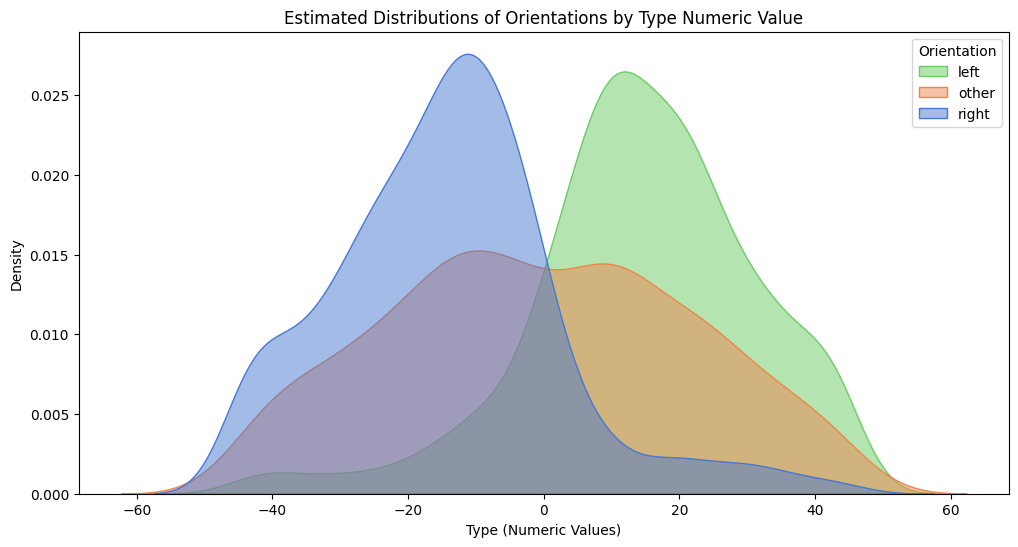

In [17]:
# Plotting estimated distributions with filled KDE and custom legend labels
plt.figure(figsize=(12, 6))
sns.kdeplot(data=overlap_strand, x='type_numeric', hue='orientation', fill=True, common_norm=False, 
            palette="muted", alpha=0.5)

plt.xlabel("Type (Numeric Values)")
plt.ylabel("Density")
plt.title("Estimated Distributions of Orientations by Type Numeric Value")

# Customize the legend labels
legend_labels = {'left': 'Left-Oriented', 'other': 'Other Orientation', 'right': 'Right-Oriented'}
plt.legend(labels=legend_labels, title="Orientation")

plt.show()

In [18]:
type_labels = ["-45.1", "-43.0", "-41.0", "-38.9", "-36.9", "-34.8", "-32.8", "-30.7", "-28.7", "-26.6", 
               "-24.6", "-22.5", "-20.5", "-18.4", "-16.4", "-14.3", "-12.3", "-10.2", "-8.2", "-6.1", 
               "-4.1", "-2.0", "0.0", "2.0", "4.1", "6.1", "8.2", "10.2", "12.3", "14.3", 
               "16.4", "18.4", "20.5", "22.5", "24.6", "26.6", "28.7", "30.7", "32.8", "34.8", 
               "36.9", "38.9", "41.0", "43.0", "45.1"]

In [19]:
total = grouped_counts.sum(axis=1)

In [20]:
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

<Figure size 2000x1000 with 0 Axes>

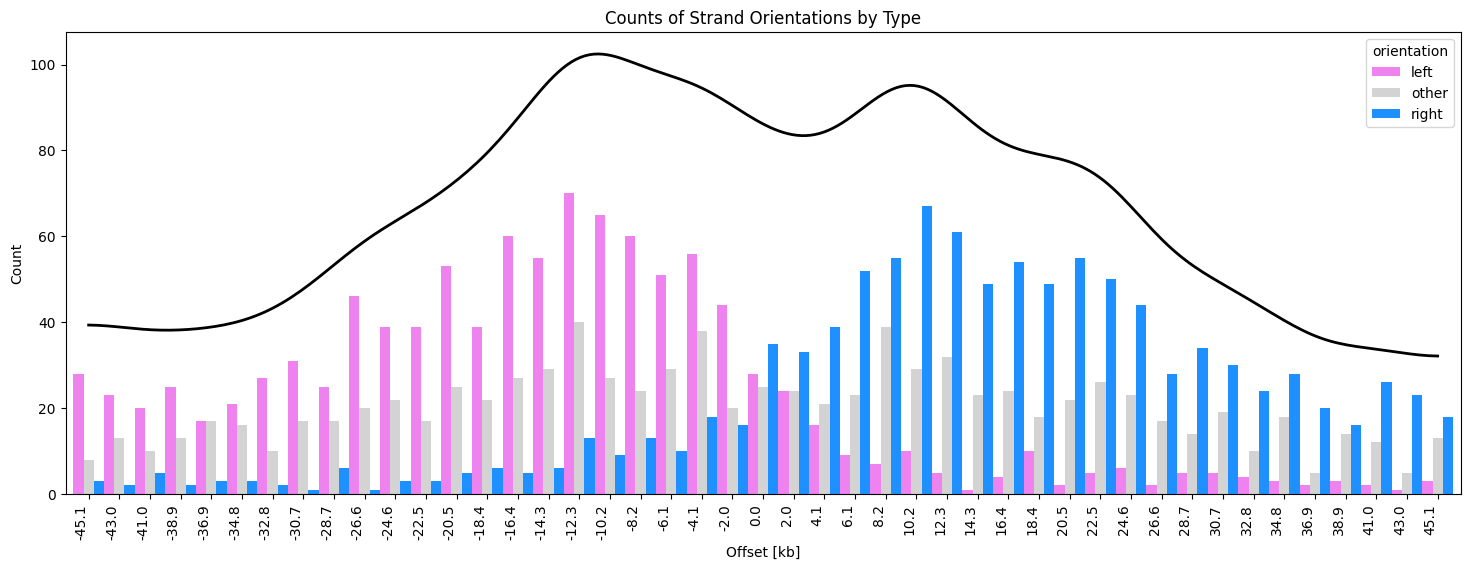

In [22]:
# Create the bar plot
plt.figure(figsize=(20,10))
grouped_counts.plot(kind='bar', stacked=False, color=['violet', 'lightgray', 'dodgerblue'], width=1, figsize=(18, 6))

# Plot the total line in the background
# plt.plot(grouped_counts.index, total, color='grey', linestyle='-', linewidth=2, label='Total Count')

# Generate a smooth x-axis range
x = np.arange(len(grouped_counts.index))
x_smooth = np.linspace(x.min(), x.max(), 300)  # Increase the resolution for smoothness

# Perform cubic spline interpolation for the total line
spline = make_interp_spline(x, total, k=5)
y_smooth = spline(x_smooth)

# Apply Gaussian filter for additional smoothing
y_smooth = gaussian_filter1d(y_smooth, sigma=10)

plt.plot(x_smooth, y_smooth, color='black', linestyle='-', linewidth=2, label='Smoothed Total Count')

# Customize plot
plt.title('Counts of Strand Orientations by Type')
plt.xlabel('Offset [kb]')
plt.ylabel('Count')
plt.xticks(ticks=range(len(type_labels)), labels=type_labels, rotation=90, ha='right')
# plt.xticks(ticks=range(len(type_order)), labels=type_order, rotation=45, ha='right')
# type_order
# plt.tight_layout()

# plt.savefig("./plots/orientation_insulation_offset.pdf", format="pdf")
# Show the plot
plt.show()

In [ ]:
# As the number of assymetric orientation is stabilized down- and upstream +-30kb, 
# we take into account the disruptions within +-30kb (precisely, 28.7kb) to classify TAD boundaries as the ones we can and cannot explain by this experiment.

### Checking the TAD metrics (from the HiC data)

In [23]:
scores_df = pd.read_csv("./all_boundaries.tsv", sep="\t")

In [24]:
overlapped_df = bf.overlap(df, scores_df, suffixes=("", "_2"), return_index=False, how="left")
max_scd_overlapped_df = overlapped_df.groupby(by=["chrom", "start", "end"])["SCD_h1_m0_t1"].max().reset_index()
mean_ins = overlapped_df.groupby(by=["chrom", "start", "end"])[["log2_insulation_score_200000_2", "n_valid_pixels_200000_2", "boundary_strength_200000_2"]].mean().reset_index()

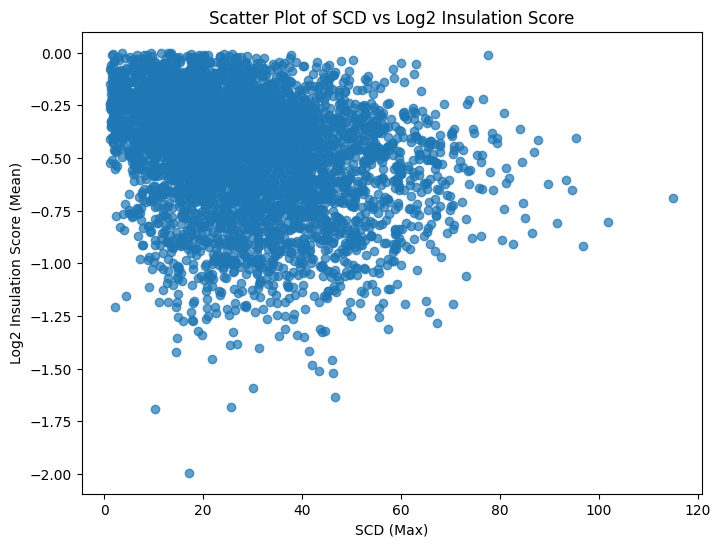

In [25]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["log2_insulation_score_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Log2 Insulation Score (Mean)')
plt.title('Scatter Plot of SCD vs Log2 Insulation Score')

# Show the plot
plt.show()

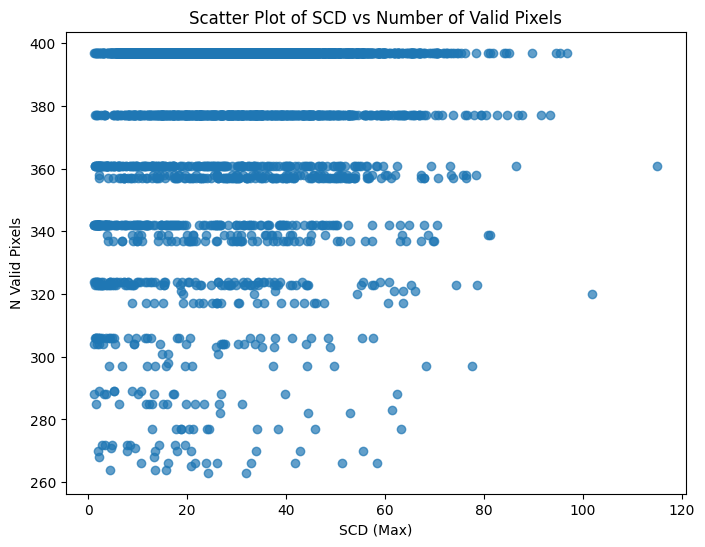

In [26]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["n_valid_pixels_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('N Valid Pixels')
plt.title('Scatter Plot of SCD vs Number of Valid Pixels')

# Show the plot
plt.show()

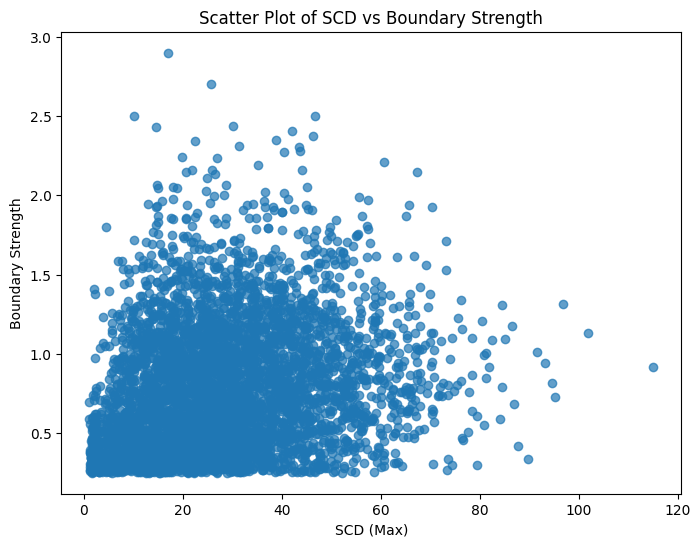

In [27]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_overlapped_df["SCD_h1_m0_t1"], mean_ins["boundary_strength_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Boundary Strength')
plt.title('Scatter Plot of SCD vs Boundary Strength')

# Show the plot
plt.show()

### Splitting TAD boundaries as explained and unexplained

In [28]:
# +-28kb
explained_types = [f"down{i}" for i in range(12,0,-1)] + [f"tad{i}" for i in range(1,6)] + [f"up{i}" for i in range(1,13)]
centered_df = df[df['type'].isin(explained_types)].reset_index(drop=True)

In [29]:
idx = centered_df.groupby(['chrom', 'start', 'end'])['SCD_h1_m0_t1'].idxmax()
result_df = df.loc[idx].reset_index(drop=True)

In [30]:
from skimage.filters import threshold_li, threshold_otsu

In [31]:
thresholds_li = threshold_li(result_df['SCD_h1_m0_t1'].values.astype('float32'))

In [32]:
thresholds_otsu = threshold_otsu(result_df['SCD_h1_m0_t1'].values.astype('float32'))

In [33]:
thresholds_li, thresholds_otsu

(18.705717, 25.394653)

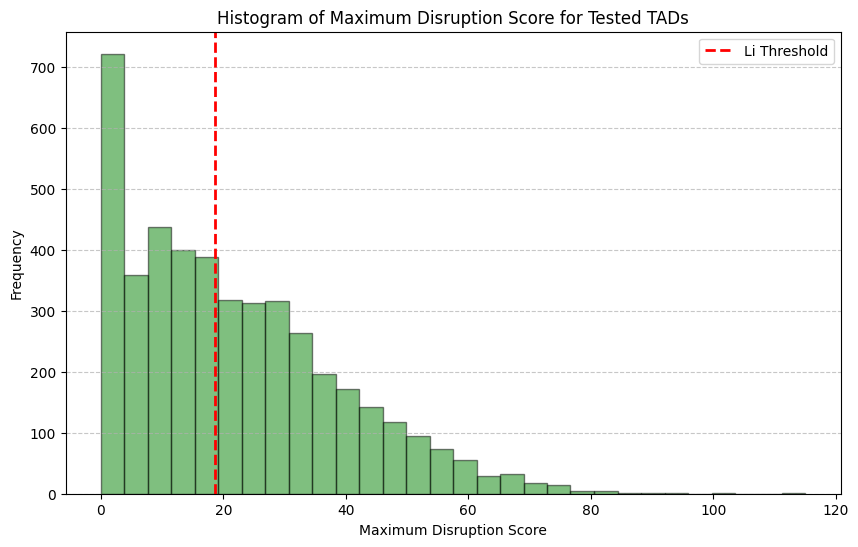

In [53]:
# Assuming explained_tads and unexplained_tads DataFrames have a column 'miss_per'
plt.figure(figsize=(10, 6))

# Plotting the histogram for explained_tads
plt.hist(result_df['SCD_h1_m0_t1'], bins=30, alpha=0.5, color='green', edgecolor='black')

# thresholds_li = threshold_li(result_df['SCD_h1_m0_t1'].values)

plt.axvline(thresholds_li, color='red', linestyle='dashed', linewidth=2, label='Li Threshold')

# # Adding labels and title
plt.xlabel('Maximum Disruption Score')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Disruption Score for Tested TADs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("./plots/max_disruption_threshold.pdf", format="pdf")

# Show the plot
plt.show()

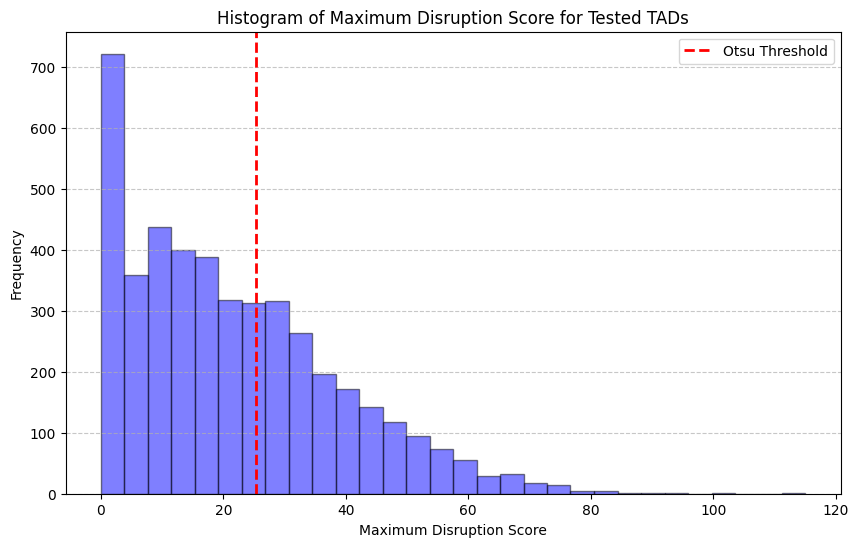

In [36]:
# Assuming explained_tads and unexplained_tads DataFrames have a column 'miss_per'
plt.figure(figsize=(10, 6))

# Plotting the histogram for explained_tads
plt.hist(result_df['SCD_h1_m0_t1'], bins=30, alpha=0.5, color='blue', edgecolor='black')

# thresholds_li = threshold_li(result_df['SCD_h1_m0_t1'].values)

plt.axvline(thresholds_otsu, color='red', linestyle='dashed', linewidth=2, label='Otsu Threshold')

# # Adding labels and title
plt.xlabel('Maximum Disruption Score')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Disruption Score for Tested TADs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig("./plots/max_disruption_threshold.pdf", format="pdf")

# Show the plot
plt.show()

In [37]:
explained_tads = result_df[result_df['SCD_h1_m0_t1'] >= thresholds_li]

In [38]:
len(result_df[result_df['SCD_h1_m0_t1'] >= thresholds_li])

2211

In [39]:
(2211 / 4474) * 100

49.418864550737595

In [ ]:
len(result_df[result_df['SCD_h1_m0_t1'] >= thresholds_otsu])

In [40]:
unexplained_tads = result_df[result_df['SCD_h1_m0_t1'] < thresholds_li]

In [41]:
len(explained_tads), len(unexplained_tads)

(2211, 2263)

In [45]:
explained_tads_central = explained_tads[explained_tads["type"].isin(["tad1", "tad2", "tad3", "tad4", "tad5"])]

In [46]:
len(explained_tads_central)

270

In [47]:
(270 / 4474) * 100

6.034868126955744

In [48]:
explained_tads_noncentral = explained_tads[~explained_tads["type"].isin(["tad1", "tad2", "tad3", "tad4", "tad5"])]

In [49]:
len(explained_tads_noncentral)

1941

In [50]:
(1941 / 4474) * 100

43.38399642378185

In [51]:
(2263 / 4474) * 100

50.581135449262405

In [ ]:
len(explained_tads[explained_tads["type"].isin([f"down{i}" for i in range(12,0,-1)])])

In [ ]:
len(explained_tads[explained_tads["type"].isin([f"tad{i}" for i in range(1,6)])])

In [ ]:
len(explained_tads[explained_tads["type"].isin([f"up{i}" for i in range(1,13)])])

In [ ]:
# explained_tads.to_csv("all_explained_boundaries.tsv", sep="\t", index=False)

In [ ]:
# unexplained_tads.to_csv("all_unexplained_boundaries.tsv", sep="\t", index=False)